In [3]:
import os
import tempfile
from pathlib import Path

import pooch
import scanpy as sc
import scvi
import torch

In [4]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.1.post1


In [5]:
sc.set_figure_params(figsize=(4, 4), frameon=False)
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}
%config InlineBackend.figure_format="retina"

In [6]:
def download_data(save_path: str, fname: str = "atac_pbmc_5k") -> str:
    """Download the data files."""
    data_paths = pooch.retrieve(
        url="https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_pbmc_5k_nextgem/atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz",
        known_hash="78e536a1508108fa5bd3b411a7484809c011f3403800369b20db05bdbfeb2284",
        fname=fname,
        path=save_path,
        processor=pooch.Untar(),
        progressbar=True,
    )
    return str(Path(data_paths[0]).parent)

In [7]:
data_path = download_data(save_dir.name)

100%|████████████████████████████████████████| 114M/114M [00:00<00:00, 139GB/s]
Untarring contents of '/private/var/folders/qj/b7mcty395l3_2cgqpsz2_0xh0000gn/T/tmp7r8ghzxf/atac_pbmc_5k' to '/private/var/folders/qj/b7mcty395l3_2cgqpsz2_0xh0000gn/T/tmp7r8ghzxf/atac_pbmc_5k.untar'


In [8]:
adata = scvi.data.read_10x_atac(data_path)
adata

AnnData object with n_obs × n_vars = 4585 × 115554
    obs: 'batch_id'
    var: 'chr', 'start', 'end'

In [9]:
(adata.X == 1).sum()

np.int64(1617289)

In [10]:
(adata.X == 2).sum()

np.int64(25632158)

In [11]:
scvi.data.reads_to_fragments(adata)

In [12]:
adata

AnnData object with n_obs × n_vars = 4585 × 115554
    obs: 'batch_id'
    var: 'chr', 'start', 'end'
    layers: 'fragments'

In [13]:
(adata.layers["fragments"] == 1).sum()

np.int64(27249447)

In [14]:
(adata.layers["fragments"] == 2).sum()

np.int64(7233892)

In [15]:
print("# regions before filtering:", adata.shape[-1])

# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)

print("# regions after filtering:", adata.shape[-1])

# regions before filtering: 115554
# regions after filtering: 33142


In [16]:
scvi.external.POISSONVI.setup_anndata(adata, layer="fragments")

In [17]:
model = scvi.external.POISSONVI(adata)
model.train()

/var/folders/qj/b7mcty395l3_2cgqpsz2_0xh0000gn/T/ipykernel_68827/3026775550.py:2: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train()
/opt/anaconda3/envs/k562_analysis/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/k562_analysis/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 18676.279. Signaling Trainer to stop.


In [18]:
model_dir = os.path.join(save_dir.name, "poissonvi_pbmc")

In [19]:
model.save(model_dir, overwrite=True)

In [20]:
POISSONVI_LATENT_KEY = "X_poissonvi"

latent = model.get_latent_representation()
adata.obsm[POISSONVI_LATENT_KEY] = latent
latent.shape

(4585, 13)

In [ ]:
adata 

AnnData object with n_obs × n_vars = 4585 × 33142
    obs: 'batch_id', '_scvi_batch', '_scvi_labels', 'clusters_poissonvi'
    var: 'chr', 'start', 'end', 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'clusters_poissonvi'
    obsm: 'X_poissonvi', 'X_umap'
    layers: 'fragments'
    obsp: 'distances', 'connectivities'

In [23]:
POISSONVI_CLUSTERS_KEY = "clusters_poissonvi"

# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep=POISSONVI_LATENT_KEY)
# compute the umap
sc.tl.umap(adata, min_dist=0.2)
# cluster the space (we use a lower resolution to get fewer clusters than the default)
sc.tl.leiden(adata, key_added=POISSONVI_CLUSTERS_KEY, resolution=0.2)

/var/folders/qj/b7mcty395l3_2cgqpsz2_0xh0000gn/T/ipykernel_68827/2628586055.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added=POISSONVI_CLUSTERS_KEY, resolution=0.2)


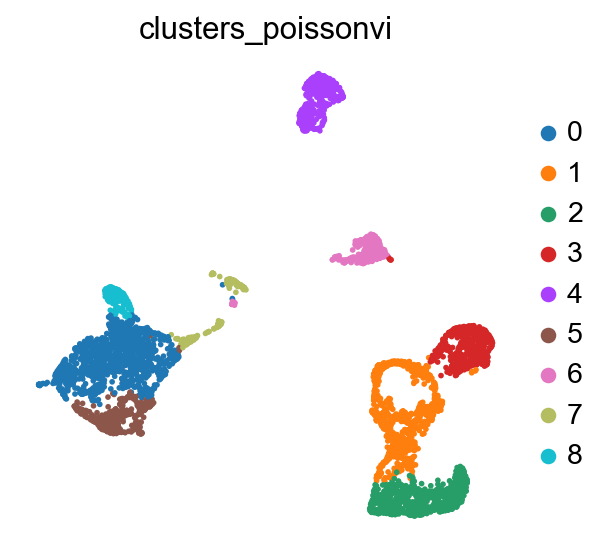

In [25]:
sc.pl.umap(adata, color=POISSONVI_CLUSTERS_KEY)